## Get the color histogram from a chroms data sample

In [2]:
import numpy as np
from tifffile import imread

sample_path = "../example_data/chroms_data_sample.tif"
chroms_data = imread(sample_path)
chroms_data = chroms_data - np.power(2,15)

In [3]:
import napari 
viewer = napari.Viewer()
color_dict = {0: 'red', 1: 'green', 2: 'blue'}
for c in range(3):
    viewer.add_image(chroms_data[:,c,:,:], colormap=color_dict[c], blending='additive', name=color_dict[c])

In [5]:
median_data = np.zeros_like(chroms_data)
median_data.shape

(20, 3, 251, 256)

In [6]:
from skimage import filters, morphology

median_data = np.zeros_like(chroms_data)
for chan in range(3):
    median_data[:,chan,:,:] = filters.median(chroms_data[:,chan,:,:], morphology.ball(2))

In [91]:
import napari 
viewer = napari.Viewer()
color_dict = {0: 'red', 1: 'green', 2: 'blue'}
for c in range(3):
    viewer.add_image(median_data[:,c,:,:], colormap=color_dict[c], blending='additive', name=color_dict[c])

In [76]:
color_limit = np.zeros((3,2), dtype=np.int16)
color_limit[:,0] = np.min(chroms_data, axis=(0,2,3)).astype(np.int16)
color_limit[:,1] = np.max(chroms_data, axis=(0,2,3)).astype(np.int16)

color_limit

array([[  274, 14793],
       [   69,  7897],
       [   65, 18005]], dtype=int16)

In [77]:
bin = 10
red_axe = np.linspace(color_limit[0,0], color_limit[0,1]-bin, ((color_limit[0,1] - color_limit[0,0]) // bin), dtype=np.int16)
green_axe = np.linspace(color_limit[1,0], color_limit[1,1]-bin, ((color_limit[1,1] - color_limit[1,0]) // bin), dtype=np.int16)
blue_axe = np.linspace(color_limit[2,0], color_limit[2,1]-bin, ((color_limit[2,1] - color_limit[2,0]) // bin), dtype=np.int16)

In [78]:
red_axe.shape

(1451,)

In [314]:
red_pixel = chroms_data[:, 0, :, :].flatten()
green_pixel = chroms_data[:, 1, :, :].flatten()
blue_pixel = chroms_data[:, 2, :, :].flatten()

color_limit = np.percentile(chroms_data,q=(0.01,99.99), axis=(0,2,3)).astype(np.int16)

red_pixel = np.clip(red_pixel, a_min=color_limit[0,0], a_max=color_limit[1,0], dtype=np.float32)
green_pixel = np.clip(green_pixel, a_min=color_limit[0,1], a_max=color_limit[1,1], dtype=np.float32)
blue_pixel = np.clip(blue_pixel, a_min=color_limit[0,2], a_max=color_limit[1,2], dtype=np.float32)

red_pixel *= (255/red_pixel.max())
green_pixel *= (255/green_pixel.max())
blue_pixel *= (255/blue_pixel.max())

chroms_data_flat = np.stack([red_pixel, green_pixel, blue_pixel]).T
chroms_data_flat.shape

(1285120, 3)

In [315]:
H, edges = np.histogramdd(
    chroms_data_flat,
    bins = 255,
    range = ((0,255), (0,255),(0,255)), 
    density = False
)

In [351]:
import napari 

viewer = napari.Viewer()
viewer.add_image(H, colormap='viridis', blending='additive')
# viewer.add_image(H==255)

<Image layer 'H' at 0x207511f0d60>

In [212]:
H_scale = np.zeros_like(H)
for i in range(H.shape[0]):
    for j in range(H.shape[1]):
        for k in range(H.shape[2]):
            if i == j == k:
                H_scale[i,j,k] = 1

In [213]:
viewer = napari.Viewer()
viewer.add_image(H_scale)
# viewer.add_image(H_scale == 255)

<Image layer 'H_scale' at 0x208cf68de50>

In [344]:
from scipy.ndimage import rotate


def align_cube(matrix):
    matrix = rotate(matrix, 45, axes=(0,1), reshape=True)
    matrix = rotate(matrix, np.arccos(np.sqrt(1/3)) * 180/np.pi, axes=(1,2), reshape=True)
    matrix = rotate(matrix, 30, axes=(0,1), reshape=True)
    # rotated_H = rotate(rot2_H, 45, axes=(0,1), reshape=True)
    return matrix

In [345]:
aligned_H = align_cube(H)
mask_aligned_H = align_cube(np.ones_like(H))

In [352]:
ternary_H = np.sum(aligned_H, axis=2)
mask_ternary_H = np.sum(mask_aligned_H[:,:,:], axis=2)

In [354]:
viewer = napari.Viewer()

viewer.add_image(aligned_H, colormap='viridis', blending='additive')


<Image layer 'aligned_H' at 0x207e9738130>

In [353]:
viewer = napari.Viewer()

viewer.add_image(ternary_H, colormap='viridis', blending='additive')
viewer.add_image(mask_ternary_H, colormap='viridis', blending='additive')

<Image layer 'mask_ternary_H' at 0x2074a123c70>

In [281]:
from ternary.helpers import simplex_iterator
for (i, j, k) in simplex_iterator(255):
    print(i/255, j/255, k/255)

0.0 0.0 1.0
0.0 0.00392156862745098 0.996078431372549
0.0 0.00784313725490196 0.9921568627450981
0.0 0.011764705882352941 0.9882352941176471
0.0 0.01568627450980392 0.984313725490196
0.0 0.0196078431372549 0.9803921568627451
0.0 0.023529411764705882 0.9764705882352941
0.0 0.027450980392156862 0.9725490196078431
0.0 0.03137254901960784 0.9686274509803922
0.0 0.03529411764705882 0.9647058823529412
0.0 0.0392156862745098 0.9607843137254902
0.0 0.043137254901960784 0.9568627450980393
0.0 0.047058823529411764 0.9529411764705882
0.0 0.050980392156862744 0.9490196078431372
0.0 0.054901960784313725 0.9450980392156862
0.0 0.058823529411764705 0.9411764705882353
0.0 0.06274509803921569 0.9372549019607843
0.0 0.06666666666666667 0.9333333333333333
0.0 0.07058823529411765 0.9294117647058824
0.0 0.07450980392156863 0.9254901960784314
0.0 0.0784313725490196 0.9215686274509803
0.0 0.08235294117647059 0.9176470588235294
0.0 0.08627450980392157 0.9137254901960784
0.0 0.09019607843137255 0.9098039215686

In [23]:

# import bisect 

# def add_pixel_in_color_hist(red_axe, red_pixel, green_axe, green_pixel, blue_axe, blue_pixel, ind): 
#     color_hist = np.zeros(red_axe.shape + green_axe.shape + blue_axe.shape)
#     color_hist[
#                 bisect.bisect(red_axe, red_pixel[ind])-1,
#                 bisect.bisect(green_axe, green_pixel[ind])-1,
#                 bisect.bisect(blue_axe, blue_pixel[ind])-1
#             ] += 1

#     return color_hist

In [ ]:
results = []

for i in range(red_pixel.shape[0]):
    print(i)
    pix = delayed(add_pixel_in_color_hist)(red_axe, red_pixel, green_axe, green_pixel, blue_axe, blue_pixel, i)
    results.append(pix)

color_hist = sum(results)

In [94]:
import bisect 

for ind_z in range(chroms_data.shape[0]):
    for ind_y in range(chroms_data.shape[2]):
        for ind_x in range(chroms_data.shape[3]):
            color_hist[
                bisect.bisect(red_axe, chroms_data[ind_z, 0, ind_y, ind_x])-1,
                bisect.bisect(green_axe, chroms_data[ind_z, 1, ind_y, ind_x])-1,
                bisect.bisect(blue_axe, chroms_data[ind_z, 2, ind_y, ind_x])-1
            ] += 1
            

In [95]:
import napari 

viewer = napari.Viewer()
viewer.add_image(color_hist)

<Image layer 'color_hist' at 0x2ec939dce20>

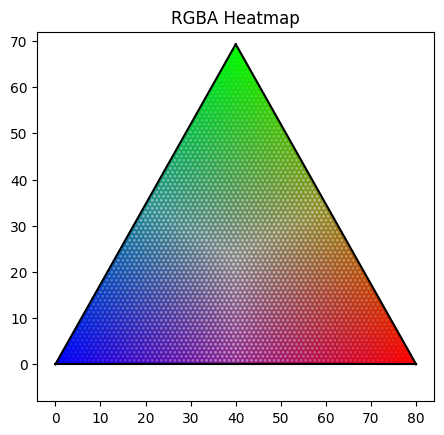

In [123]:
import math
from matplotlib import pyplot as plt
import ternary

def color_point(x, y, z, scale):
    w = 255
    x_color = x * w / float(scale)
    y_color = y * w / float(scale)
    z_color = z * w / float(scale)
    r = math.fabs(x_color) / w
    g = math.fabs(y_color) / w
    b = math.fabs(z_color) / w
    # r = math.fabs(w - x_color) / w
    # g = math.fabs(w - y_color) / w
    # b = math.fabs(w - z_color) / w
    return (r, g, b, (max([r,g,b])/(r+g+b)))
    # return (r, g, b, 1.)


def generate_heatmap_data(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = color_point(i, j, k, scale)
    return d


scale = 80
data = generate_heatmap_data(scale)
figure, tax = ternary.figure(scale=scale)
tax.heatmap(data, style="hexagonal", use_rgba=True)
tax.boundary()
tax.set_title("RGBA Heatmap")
figure.delaxes(figure.axes[1])
plt.show()